# Redes Neuronales

En este notebook vamos a construir la unidad básica de las redes neuronales, el Perceptrón. Tiene dos partes:
1. **Perceptrón 2D**: vamos a entrenar un Perceptrón con Keras sobre un dataset ficticio. Exploramos cómo son las fronteras en 2D. Limitaciones del Perceptrón. Generamos un dataset no-linealmente separable y vemos cómo responde el Perceptrón.
2. **MNIST**: vamos a trabajar con este conocido dataset. El objetivo es identificar dígitos, del 0 al 9, escritos a manos. Primero entrenaremos una red neuronal de una capa y luego una Red Neuronal de más capas.

## 1. Perceptrón en 2D

Vamos a generar un dataset sintético con unas funciones que ya vienen incorporadas en scikit-learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
from sklearn.datasets.samples_generator import make_blobs, make_moons
X, y = make_blobs(n_samples=1000, centers=2, n_features=2,
                  random_state=0)

X, y = make_moons(n_samples=1000, random_state=0)

In [3]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


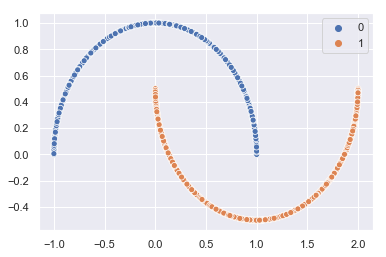

In [4]:
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y)
plt.show()

Reescalamos los datos

In [5]:
X[:,0] = (X[:,0] - X[:,0].mean())/X[:,0].std()
X[:,1] = (X[:,1] - X[:,1].mean())/X[:,1].std()

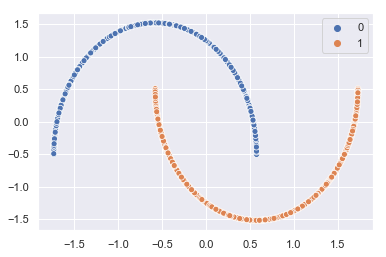

In [6]:
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y)
plt.show()

Definimos el modelo a entrenar y volvemos a mirar algunas de sus características.

In [7]:
model = Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [8]:
# optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.0, beta_2=0.0, epsilon=None, decay=0.0, amsgrad=False)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.0, beta_2=0.0, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
history = model.fit(X, y, epochs=250, validation_split=0.25, verbose=False)
# history = model.fit(X, y, epochs=250, validation_split=0.25)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(history.history.keys())

dict_keys(['accuracy', 'val_accuracy', 'val_loss', 'loss'])


Notar que se agregaron una keys, asociadas al set de validación. Grafiquemos.

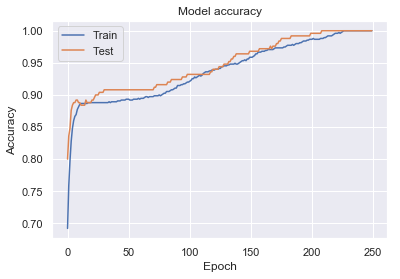

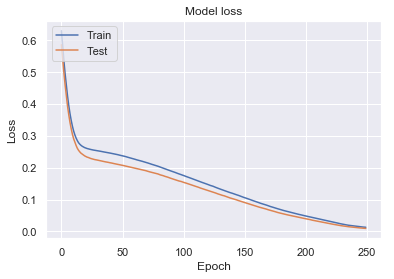

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

¿Cuántos parámetros tiene ahora el modelo?

In [13]:
print(model.get_weights())

[array([[-3.0520563 ,  0.0874375 , -0.06004226, -0.05720151, -0.05908182,
        -2.4638517 ,  1.6655837 ,  0.09117509, -0.37021902,  0.9232546 ],
       [-0.40430662, -0.03919967, -0.19626643,  1.312962  ,  1.3164512 ,
        -0.46668112, -0.31123158,  0.53800124,  1.4106677 , -1.1124241 ]],
      dtype=float32), array([-1.6058556 , -0.1599997 , -0.27099526, -0.46607316, -0.466102  ,
        1.2639707 , -0.9933067 ,  0.8920288 ,  0.19880177, -0.69399774],
      dtype=float32), array([[-5.4981127 ],
       [-0.37843502],
       [-0.09715947],
       [-2.0736837 ],
       [-2.1518784 ],
       [ 3.1106594 ],
       [ 3.200855  ],
       [-1.4981748 ],
       [-1.2516078 ],
       [ 2.063814  ]], dtype=float32), array([-1.2397759], dtype=float32)]


Y graficamos las fronteras de decisión. ¿Notan que ya no es una frontera abrupta, sino que hay una zona de cambio?¿A qué se debe?

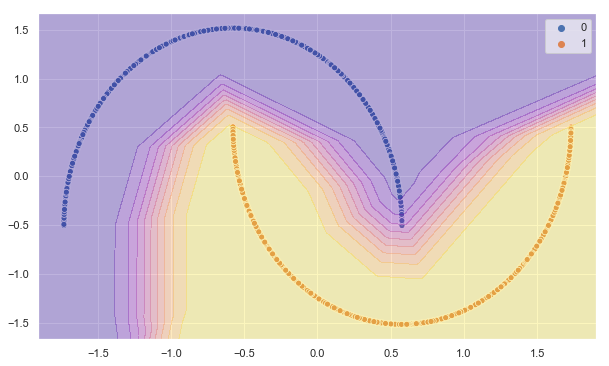

In [14]:
plt.figure(figsize = (10,6))

ax = sns.scatterplot(x = X[:,0], y = X[:,1], hue = y)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, levels = 10, alpha=0.3, cmap = 'plasma')
plt.show()

**Ejercicio:** volver a correr esta sección, pero reemplazando la función que genera los datos `make_blobs` por `make_moons`. ¿Qué problema ven en el resultado?

**Ejercicio**: con los datos producidos por `make_moons`, agregar una capa a la red neuronal, con 10 neuronas y función de activación `relu`.

## 2. MNIST

El dataset de MNIST es un dataset muy conocido. Consiste en dígitos escritos a mano. Muchas modelos de redes neuronales son probados primeros en este set. Pueden encontrar una descripción más detallada, y un ranking de modelos con su desempeño, en el siguiente link.

https://en.wikipedia.org/wiki/MNIST_database

Vamos a arrancar con una sola capa, con una activación `softmax`, ya que se trata de diez clases.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os #esta libreria permite trabajar con funciones del sistema operativo 
import random

from sklearn.model_selection import train_test_split

**1. Carga de datos**

Cada instancia del dataset es una imagen guardada en una carpeta con la etiqueta correspondiente.

In [16]:
directorio = 'data/MNIST/'

Miramos las carpetas que hay adentro de la carpeta MNIST

In [17]:
print(os.listdir(directorio))

['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']


Creamos los contenedores vacíos

In [18]:
todas_imagenes = []
y_todas_imagenes = []

y los llenamos.

In [19]:
digitos = np.arange(0,10)
for digito in digitos:
    directorio = 'data/MNIST/' + str(digito) + '/'
    print(digito, directorio)
    print('Hay', len(os.listdir(directorio)),'imagenes')
    for imagen in os.listdir(directorio):
        todas_imagenes.append(plt.imread(directorio + imagen))
        y_todas_imagenes.append(digito)
        
todas_imagenes = np.array(todas_imagenes)
y_todas_imagenes = np.array(y_todas_imagenes)

0 data/MNIST/0/
Hay 4132 imagenes
1 data/MNIST/1/
Hay 4684 imagenes
2 data/MNIST/2/
Hay 4177 imagenes
3 data/MNIST/3/
Hay 4351 imagenes
4 data/MNIST/4/
Hay 4072 imagenes
5 data/MNIST/5/
Hay 3795 imagenes
6 data/MNIST/6/
Hay 4137 imagenes
7 data/MNIST/7/
Hay 4401 imagenes
8 data/MNIST/8/
Hay 4063 imagenes
9 data/MNIST/9/
Hay 4188 imagenes


**2. Preprocesado**

**Ejercicio:** Mirar el `shape` de `X` y responder: ¿Cuántas instancias son?¿Qué ancho y largo tienen las imágenes?¿Cuántas bandas?

In [21]:
print(todas_imagenes.shape, y_todas_imagenes.shape)
n_instancias = todas_imagenes.shape[0]
ancho_imagen = todas_imagenes.shape[1]
largo_imagen = todas_imagenes.shape[2]

(42000, 28, 28) (42000,)


Miramos una imagen al azar.

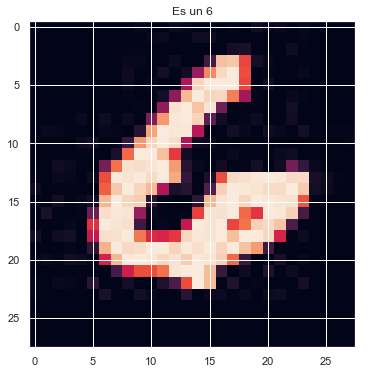

In [22]:
idx_imagen = np.random.randint(0,todas_imagenes.shape[0])
plt.figure(figsize = (6,6))
plt.title('Es un ' + str(y_todas_imagenes[idx_imagen]))
plt.imshow(todas_imagenes[idx_imagen, :, :])
plt.show()

**Ejercicio:** Crear un arreglo `X` que sea igual a `todas_imagenes`, pero de forma `(n_instancias, largo_imagen * ancho_imagen)`.

In [23]:
X = todas_imagenes.reshape(n_instancias, largo_imagen*ancho_imagen)
print(X.shape)

(42000, 784)


**Ejercicio:** Reescalar las imágenes entre 0 y 1.

In [24]:
X = X/255

**Ejercicio:** usar el `to_categorical` de Keras para llevar `y_todas_imagenes` a una columna con unos y ceros para cada clase `y` (One Hot Encoding).

In [25]:
from keras.utils import to_categorical
y =to_categorical(y_todas_imagenes)
print(y.shape)

(42000, 10)


**Ejercicio:** hacer un `train_test_split`. Usar el 20% del dataset como conjunto de test.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

**3. Entrenamiento del modelo**

Comenzar entrenando un Red Neuronal de una capa, con diez neuronas, función de activación `softmax` y pérdida `categorical_crossentropy`. Usar como optimizador `Adam` y `epoch = 20`.

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras

model = Sequential()
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(8, activation='relu'))
# model.add(Dense(800, activation='relu'))
model.add(Dense(10, activation='softmax'))

# optimizador = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizador = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizador,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

NameError: name 'X_train' is not defined

**Ejercicio:** ¿cuántos parámetros tiene el modelo? Recordar que hay una función de Keras que hace un *informe* de la red neuronal.

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


**Ejercicio:** Graficar la pérdida y la exactitud en función de *epochs* para validación y entrenamiento.

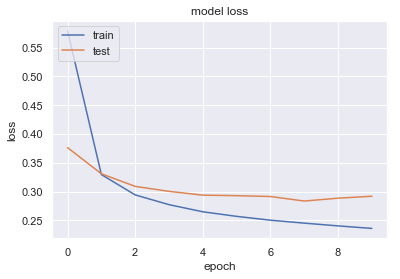

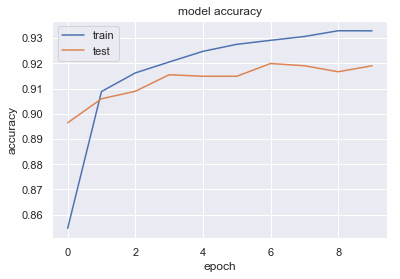

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**4. Evaluación de los resultados.**

**Ejercicio**: predecir las etiquetas de todo el set de testeo.

In [30]:
y_test_pred = model.predict(X_test)

Esto sirve para pasar de probabilidades a la etiqueta en sí. En este caso, la etiqueta es el dígito, y corresponde al número de columna.

In [31]:
y_test_pred = np.argmax(y_test_pred, axis = 1)
y_test_pred.shape

(8400,)

**Ejercicio:** Calcular exactitud y la matriz de confusión para el conjunto de entrenamiento.

In [32]:
from sklearn.metrics import confusion_matrix

y_test = np.argmax(y_test,axis = 1)

confusion_matrix(y_test, y_test_pred)

array([[801,   0,   7,   1,   2,   4,   7,   0,   4,   1],
       [  0, 908,   7,   6,   0,   2,   2,   2,   8,   2],
       [  3,   5, 770,  13,   7,   3,   6,  10,  15,   3],
       [  2,   3,  37, 781,   0,  18,   1,   6,  15,   7],
       [  1,   3,  10,   1, 749,   0,   7,   1,   8,  34],
       [  6,   4,  12,  27,   5, 666,   8,   4,  17,  10],
       [ 10,   1,  11,   1,   4,   8, 787,   0,   5,   0],
       [  2,   3,  15,   1,  11,   0,   0, 821,   0,  27],
       [  6,  17,  10,  32,   2,  20,   2,   1, 714,   9],
       [  1,   5,   1,  15,  27,   4,   0,  22,   7, 756]])

In [33]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.9229761904761905

**Ejercicio:** ¿Dónde se está confundiendo? Graficar algunos ejemplos.

In [34]:
errores = y_test != y_test_pred

In [35]:
imagenes_errores = X_test[errores,:]
y_test_errores = y_test[errores]
y_test_pred_errores = y_test_pred[errores]
print(imagenes_errores.shape)

(647, 784)


In [36]:
imagenes_errores = imagenes_errores.reshape(imagenes_errores.shape[0], ancho_imagen, largo_imagen)
print(imagenes_errores.shape)

(647, 28, 28)


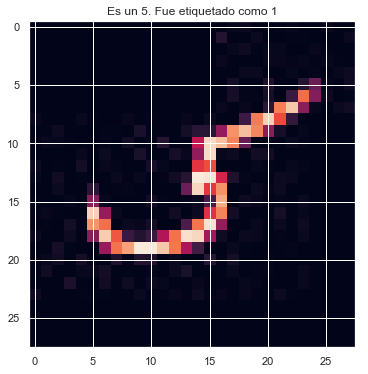

In [37]:
idx_imagen = np.random.randint(0,imagenes_errores.shape[0])
plt.figure(figsize = (6,6))
plt.title('Es un ' + str(y_test_errores[idx_imagen]) +'. Fue etiquetado como ' + str(y_test_pred_errores[idx_imagen]))
plt.imshow(imagenes_errores[idx_imagen, :, :])
plt.show()

**Ejercicio:** Volver a entrenar, pero agregando una capa con 800 neuronas y función de activación `relu`.

**Extra:** En el caso del Perceptrón de una sola capa (10 neuronas de salida y nada más), ¿qué está viendo la red?

Notar que los parámetros para cualquiera de las neuronas de salida son 784 + Bias. Como hay 10 neuronas, son 7850 parámetros. Keras, con las función `model.get_weights()`, devuelve todos los pesos y *biases* de cada neurona. Seleccionado la primera componente, descartamos los *biases*.

In [38]:
ws = model.get_weights()[0]
print(ws.shape)

(784, 10)


Notar que son 784: un peso por cada pixel de la imagen - sin el bias - por diez neuronas.

Como son 784, podemos llevarlos a la forma `(28,28)` y graficarlos como si fueran una imagen. Hacemos eso para todas las neuronas.

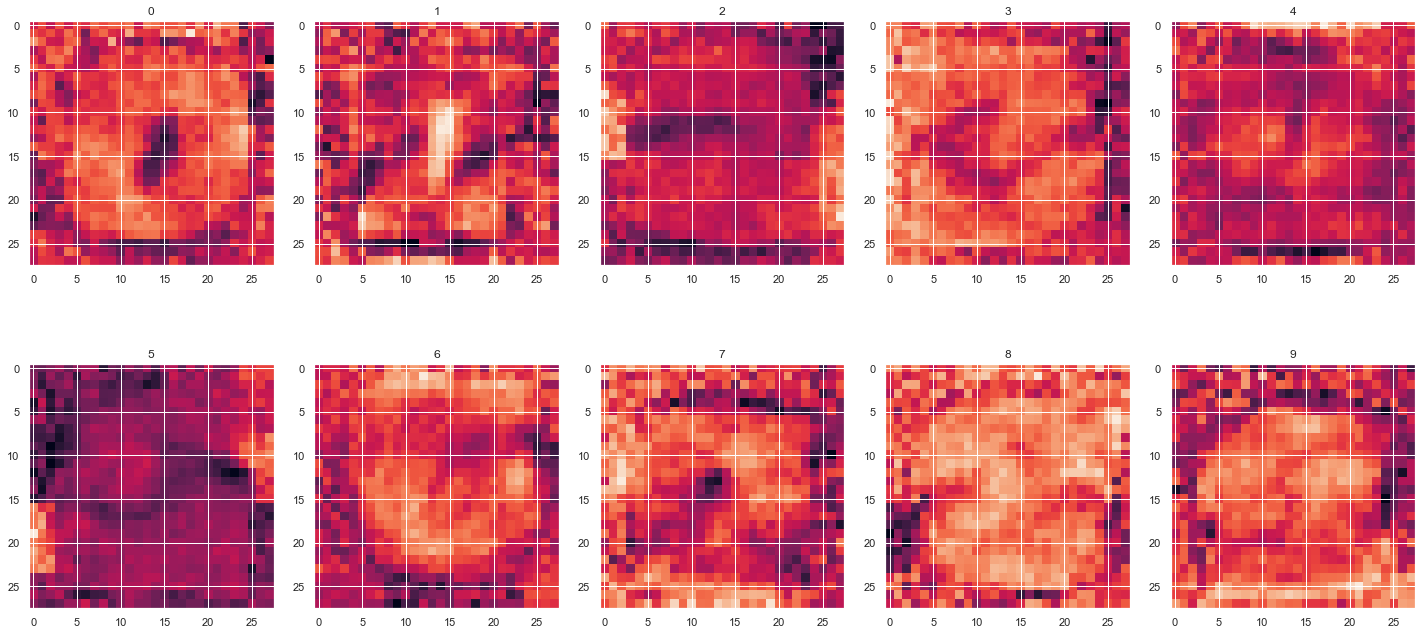

In [39]:
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    w0 = ws[:,i]
    plt.title(i)
    plt.imshow(w0.reshape(28,28))
plt.tight_layout()
plt.show()